In [1]:
import torch
import cxgnncomp as cxgc
import cxgnncomp_backend
import matplotlib.pyplot as plt
import numpy


def run(head, feat, hidden, edge, node, rel, node_dst):
    nn = []
    graph = []
    nn_opt = []
    graph_opt = []
    # RGCN
    nn_workload = feat * hidden * edge
    graph_workload = (hidden + feat) * edge

    nn_workload_opt = node * feat * hidden
    graph_workload_opt = node * feat + edge * hidden
    print(
        f"RGCN\t{nn_workload}\t{graph_workload}\t{nn_workload_opt}\t{graph_workload_opt}"
    )
    nn.append(nn_workload)
    graph.append(graph_workload)
    nn_opt.append(nn_workload_opt)
    graph_opt.append(graph_workload_opt)

    # GAT
    nn_workload = feat * hidden * node * head + node * head * hidden
    graph_workload = edge * head * hidden * 2

    nn_workload_opt = (
        feat * hidden * head + feat * node * head + (feat * hidden * node * head)
    )
    graph_workload_opt = edge * head * feat * 2

    print(
        f"GAT\t{nn_workload}\t{graph_workload}\t{nn_workload_opt}\t{graph_workload_opt}"
    )
    nn.append(nn_workload)
    graph.append(graph_workload)
    nn_opt.append(nn_workload_opt)
    graph_opt.append(graph_workload_opt)

    # SAGE
    nn_workload = feat * hidden * node + feat * hidden * node_dst
    graph_workload = feat * edge * 2

    nn_workload_opt = node_dst * feat * hidden * 2
    graph_workload_opt = min(feat, hidden) * edge * 2

    print(
        f"SAGE\t{nn_workload}\t{graph_workload}\t{nn_workload_opt}\t{graph_workload_opt}"
    )
    nn.append(nn_workload)
    graph.append(graph_workload)
    nn_opt.append(nn_workload_opt)
    graph_opt.append(graph_workload_opt)

    return numpy.array(nn), numpy.array(graph), numpy.array(nn_opt), numpy.array(graph_opt)


def exec(feat=128, hidden=256):
    batch = torch.load("../../../../data/graph.pt")
    ptr = batch["ptr"].cuda()
    idx = batch["idx"].cuda()
    num_node_in_layer = batch["num_node_in_layer"]
    x = torch.randn([num_node_in_layer[-1], feat], device="cuda")
    weight = torch.randn([feat, hidden], device=x.device)
    cxgc.prof("mm", "node", lambda: torch.mm(x, weight))
    cxgc.prof("mm", "node", lambda: torch.mm(x, weight))
    res_nn = cxgc.prof("mm", "node", lambda: torch.mm(x, weight))
    res_graph = cxgc.prof(
        "spmm",
        "",
        lambda: cxgnncomp_backend.sage_mean_forward(x, ptr, idx, num_node_in_layer[-2]),
    )
    print(f"nn: {res_nn[0]}, graph: {res_graph[0]}")
    nn_per_op = res_nn[0] / (hidden * feat * x.shape[0])
    graph_per_op = res_graph[0] / (feat * idx.shape[0])
    # print(
    #     f"nn: {res_nn[0]/(hidden * feat * x.shape[0])}, graph: {res_graph[0] /(feat * idx.shape[0])}"
    # )
    # tuner = cxgc.Tuner()
    # output = tuner.tune_graph(ptr.shape[0] - 1, idx.shape[0], x.shape[1],
    #                           cxgnncomp_backend.run_spmm_configurable,
    #                           [ptr, idx, x, ptr.shape[0] - 1])
    return nn_per_op, graph_per_op

/home/huangkz/.venvs/fresh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tuner lazy True
Loading cache table


In [2]:
nn_per_op, graph_per_op = exec()

mm node: (3.463167905807495, 3.462143898010254, 3.463167905807495)
mm node: (3.477504014968872, 3.4752511978149414, 3.5229694843292236)
mm node: (3.5031039714813232, 3.463167905807495, 3.5051519870758057)
spmm : (15.27347183227539, 15.209471702575684, 15.285247802734375)
nn: 3.5031039714813232, graph: 15.27347183227539


In [3]:
def plot(nn, graph, nn_opt, graph_opt, nn_per_op, graph_per_op):
    labels = ["RGCN", "GAT", "SAGE"]
    x0 = [float(i) for i in range(len(labels))]
    x1 = [0.2 + float(i) for i in range(len(labels))]
    x2 = [0.4 + float(i) for i in range(len(labels))]
    # x2 = [0.4 + float(i) for i in range(len(labels))]
    overall = graph * graph_per_op / 2 + nn * nn_per_op
    plt.bar(x0, (graph * graph_per_op / 2 + nn * nn_per_op) / overall, width=0.2, label="Graph-base")
    plt.bar(x0, (nn * nn_per_op) / overall, width=0.2, label="NN-base")
    plt.bar(x1, (graph_opt * graph_per_op / 2 + nn_opt * nn_per_op) / overall, width=0.2, label="Graph-opt")
    plt.bar(x1, (nn_opt * nn_per_op) / overall, width=0.2, label="NN-opt")
    plt.xticks([i + 0.1 for i in range(len(labels))], labels)
    plt.legend()

RGCN	76430901248	895674624	5549031424	618792320
GAT	89478131712	19107725312	89131841536	9553862656
SAGE	11098062848	597116416	11098062848	597116416


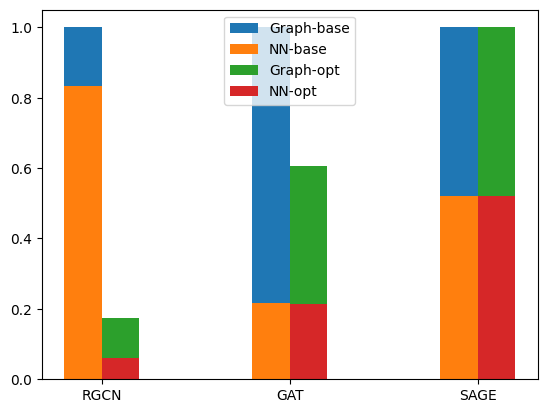

In [4]:
# get arxiv data
head = 16
feat = 128
hidden = 256
edge = 2332486
node = 169343
rel = 7
# print(nn_per_op, graph_per_op)
nn, graph, nn_opt, graph_opt = run(head, feat, hidden, edge, node, rel, node_dst=node)
# print(nn, graph, nn_opt, graph_opt)

plot(nn, graph, nn_opt, graph_opt, nn_per_op, graph_per_op)



dataset prepared torch.Size([153356]) torch.Size([1530846]) torch.Size([1270184, 128]) tensor([   1000,   12429,  153355, 1270184])
RGCN	50162761728	587844864	41621389312	554480128
GAT	671144902656	12540690432	668544090112	6270345216
SAGE	46646525952	391896576	10050273280	391896576


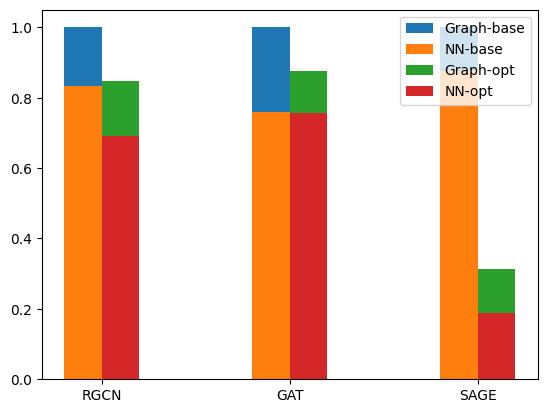

In [7]:
# get papers100M data
dset = "papers100M"
x, ptr, idx, b = cxgc.prepare_data_sampled_graph(
    dset=dset, feat_len=128, num_head=1, num_seeds=1000, need_edge_index=False
)
feat = 128
node = b["num_node_in_layer"][-1]
node_dst = b["num_node_in_layer"][-2]
edge = idx.shape[0]
nn, graph, nn_opt, graph_opt = run(head, feat, hidden, edge, node, rel, node_dst=node_dst)
plot(nn, graph, nn_opt, graph_opt, nn_per_op, graph_per_op)